# 0. 사전 설치 및 라이브러리 불러오기

※ 런타임 - 런타임 유형 변경 - 하드웨어 가속기=GPU로 설정

### 0-0. 사전 설치

In [ ]:
# 파일을 [구글드라이브]에서 [현재 세션]으로 다운로드하기 위한 라이브러리 설치
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 데이터 파일, 모델 사전학습 파일 다운로드 및 압축 해제
import os
import gdown

# 데이터셋 다운로드
url = "https://drive.google.com/file/d/1ehmd3zElbtWi46LEEsPYoaMox-YEPA2g/view?usp=share_link"
output = "dataset.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

# 사전학습 모델 다운로드
url = "https://drive.google.com/file/d/1vk-VPF3X20_E1K3IgvTI5ZxtF6ql5v3l/view?usp=share_link"
output = "model.zip"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

# 압축해제
os.system("unzip dataset.zip -d dataset")
os.system("unzip model.zip -d pretrained")

Downloading...
From: https://drive.google.com/uc?id=1ehmd3zElbtWi46LEEsPYoaMox-YEPA2g
To: /content/dataset.zip
100%|██████████| 40.0M/40.0M [00:01<00:00, 36.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vk-VPF3X20_E1K3IgvTI5ZxtF6ql5v3l
To: /content/model.zip
100%|██████████| 230M/230M [00:04<00:00, 52.5MB/s]


0

###0-1. 라이브러리 불러오기

In [ ]:
import glob                                                                                                                     # 파일 목록을 보여주기 위한 라이브러리
from tqdm import tqdm                                                                                                     # 반복수행에서 진행 단계를 보여주기 위한 라이브러리
import shutil                                                                                                                    # 파일 복사, 이동 등의 명령을 위한 라이브러리
from PIL import Image                                                                                                       # 이미지 파일 처리 라이브러리
import numpy as np                                                                                                          # 수치연산 라이브러리
import tensorflow as tf                                                                                                       # 텐서플로우 딥러닝 프레임워크 
import random                                                                                                                 # 난수 생성 라이브러리
import matplotlib.pyplot as plt                                                                                             # 시각화 라이브러리

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Add, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

SEED = 123                                                                                                                      # 이하 무작위로 결정되는 요소들의 난수를 고정하여 재현 가능하게 설정
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 1. 데이터 사전 준비

### 1-1. 데이터 경로 설정

*   Segmentation task의 데이터셋은 입력=이미지, 정답=마스크로 구성
*   모델의 출력은 마스크를 클래스에 맞게 One-Hot Encoding한 형상으로 구성

In [ ]:
# train, test 데이터셋 폴더 경로 지정
train_image_dir = '/content/dataset/train_dataset/images'                                                     # 학습 데이터 입력 이미지
train_mask_dir = '/content/dataset/train_dataset/masks'                                                       # 학습 데이터 정답 마스크
test_image_dir = '/content/dataset/test_dataset/images'                                                       # 평가 데이터 입력 이미지
test_mask_dir = '/content/dataset/test_dataset/masks'                                                         # 평가 데이터 정답 마스크

In [ ]:
# 폴더내 파일 경로 지정
# image와 mask 경로를 동일한 순서로 지정하기 위해 path에 str 함수 replace 적용
train_image_paths = glob.glob(f'{train_image_dir}/*')
train_mask_paths = [path.replace('images', 'masks') for path in train_image_paths]

test_image_paths = glob.glob(f'{test_image_dir}/*')
test_mask_paths = [path.replace('images', 'masks') for path in test_image_paths]

# 데이터 개수 확인
print('train image:', len(train_image_paths))
print('train mask:', len(train_mask_paths))
print('test image:', len(test_image_paths))
print('test mask:', len(test_mask_paths))

train image: 300
train mask: 300
test image: 100
test mask: 100


In [ ]:
# train data 순서 확인
train_image_paths[0], train_mask_paths[0]

('/content/dataset/train_dataset/images/water_body_2293.jpg',
 '/content/dataset/train_dataset/masks/water_body_2293.jpg')

In [ ]:
# test data 순서 확인
test_image_paths[30], test_mask_paths[30]

('/content/dataset/test_dataset/images/water_body_1218.jpg',
 '/content/dataset/test_dataset/masks/water_body_1218.jpg')

### 1-2. Data load & Visualization

data size: (470, 627)


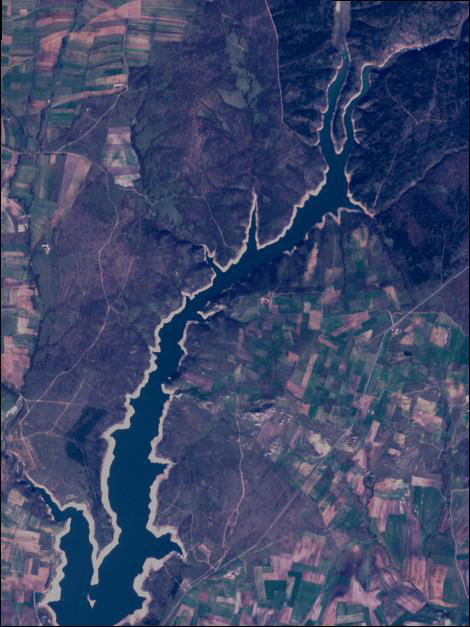

In [ ]:
# PIL의 Image 모듈 활용한 이미지 데이터 로드
# 이미지 원본 크기로 시각화
data_path = train_image_paths[0]
img = Image.open(data_path)
print('data size:', img.size)
img 

data size: (627, 470, 3)


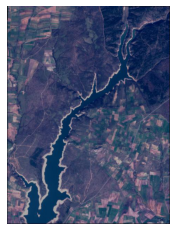

In [ ]:
# 데이터 로드 후 학습을 위한 array 변환
# figure size에 따른 시각화
def plot_image(data_array, title=None):
    plt.imshow(data_array)
    plt.title(title)
    plt.axis('off')

data_path = train_image_paths[0] # path 지정
img = Image.open(data_path)       # 데이터 로드
img = np.array(img)               # array 변환

print('data size:', img.shape)
plot_image(img)



image shape: (627, 470, 3)
mask shape: (627, 470, 3)


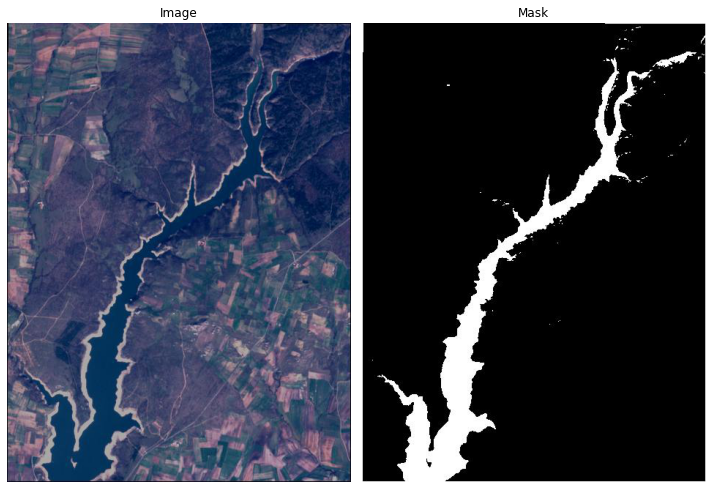



image shape: (88, 70, 3)
mask shape: (88, 70, 3)


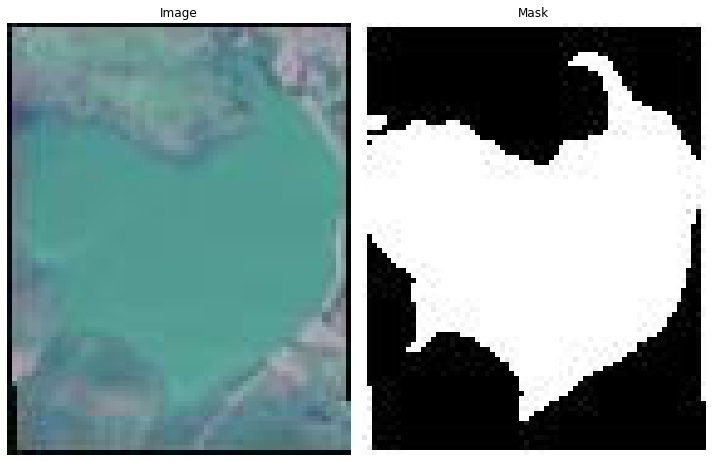



image shape: (636, 410, 3)
mask shape: (636, 410, 3)


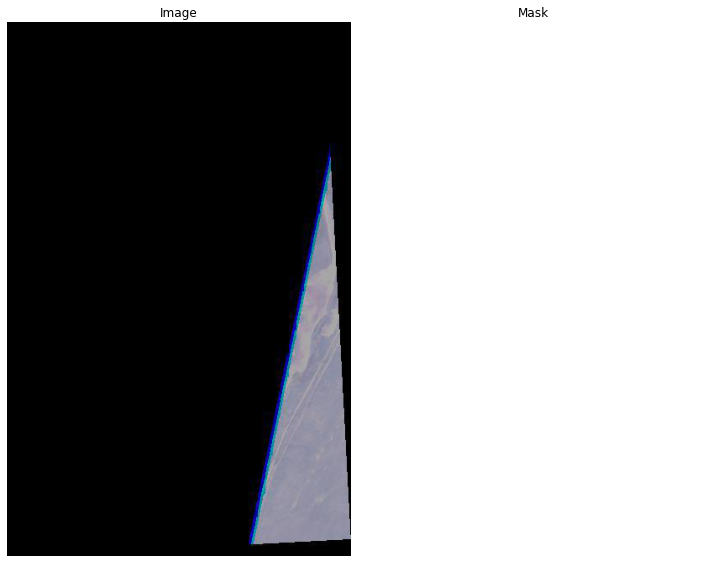



image shape: (209, 200, 3)
mask shape: (209, 200, 3)


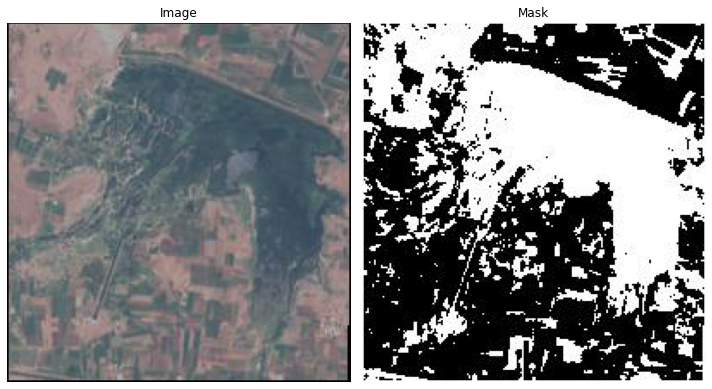



image shape: (110, 101, 3)
mask shape: (110, 101, 3)


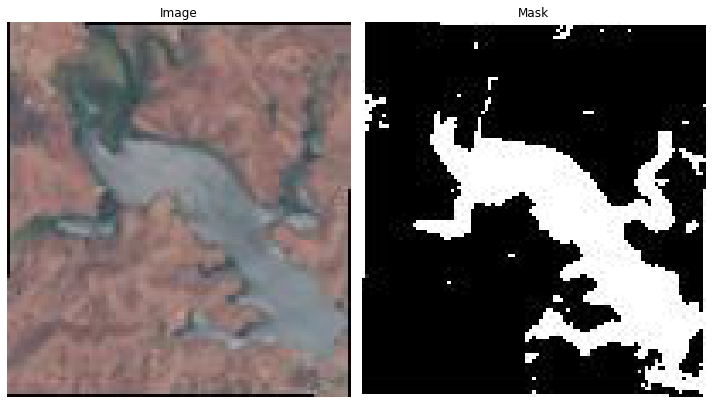



image shape: (733, 702, 3)
mask shape: (733, 702, 3)


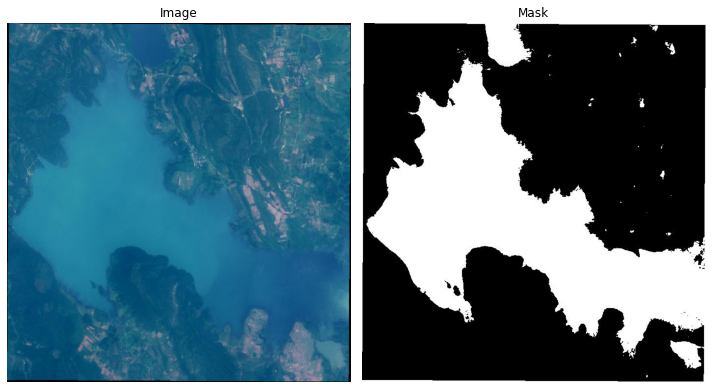



image shape: (322, 255, 3)
mask shape: (322, 255, 3)


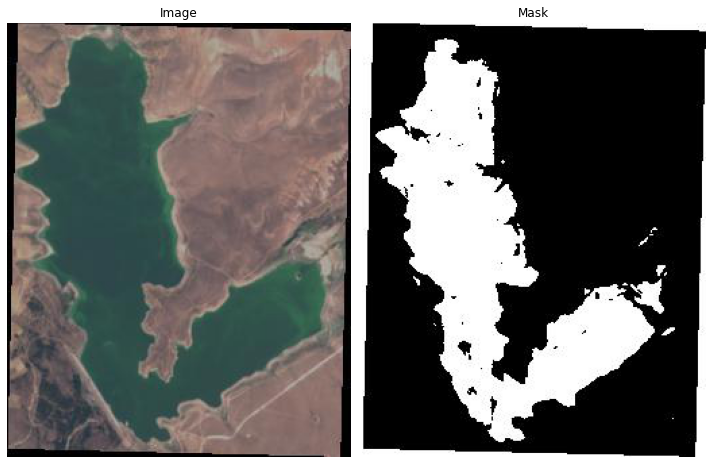



image shape: (171, 143, 3)
mask shape: (171, 143, 3)


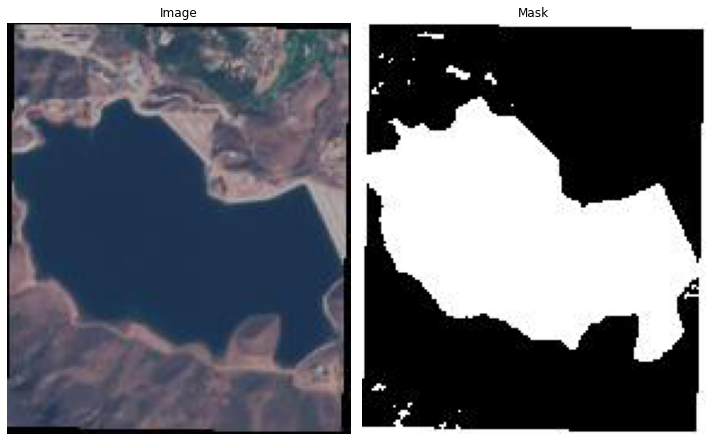



image shape: (888, 696, 3)
mask shape: (888, 696, 3)


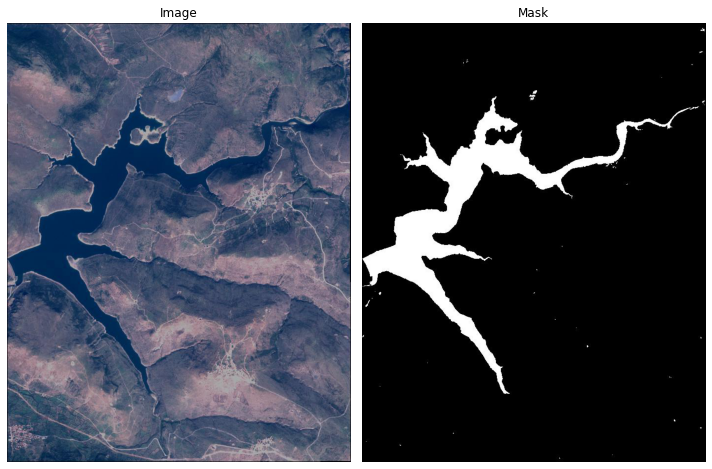



image shape: (929, 669, 3)
mask shape: (929, 669, 3)


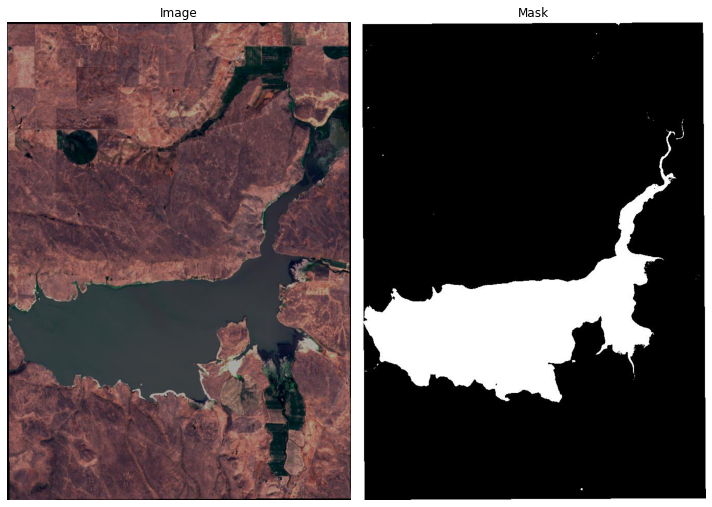

In [ ]:
# image와 mask 함께 시각화
for idx in range(0, 100, 10):
    image_path, mask_path = train_image_paths[idx], train_mask_paths[idx]  # path 지정
    img = np.array(Image.open(image_path))    # 데이터 로드 및 array 변환
    mask = np.array(Image.open(mask_path))    # 데이터 로드 및 array 변환
    print('\n')
    print('image shape:', img.shape)
    print('mask shape:', mask.shape)

    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    plot_image(img, title="Image")
    
    plt.subplot(1,2,2)
    plot_image(mask, title="Mask")
    
    plt.tight_layout()
    plt.show()

### 1-3. Pre-processing
* 이미지 데이터와 마스크의 크기가 파일마다 제각각 다르기 때문에 일괄적으로 256x256으로 리사이즈

In [ ]:
def get_resize_data(path, size=(256, 256)):
    data = np.array(Image.open(path))       # 데이터 로드 및 array 변환
    data = tf.image.resize(data/255., size=size) # resize
    return data

## 학습을 위한 train, test dataset image(input), mask(output) resize
resize_height, resize_width = 256, 256

# 데이터 틀 생성 (데이터 개수 x height x width x channel)
train_image = np.zeros((len(train_image_paths), resize_height, resize_width, 3)) 
train_mask = np.zeros((len(train_mask_paths), resize_height, resize_width, 3))
test_image = np.zeros((len(test_image_paths), resize_height, resize_width, 3))
test_mask = np.zeros((len(test_mask_paths), resize_height, resize_width, 3))

print('train image shape:', train_image.shape)
print('train mask shape:', train_mask.shape)
print('test image shape:', test_image.shape)
print('test mask shape:', test_mask.shape)

train_image[0] # 데이터 틀 확인

train image shape: (300, 256, 256, 3)
train mask shape: (300, 256, 256, 3)
test image shape: (100, 256, 256, 3)
test mask shape: (100, 256, 256, 3)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [ ]:
# train 데이터 로드 및 resize
for idx, (image_path, mask_path) in enumerate(zip(train_image_paths, train_mask_paths)):
    train_image[idx] = get_resize_data(image_path, size=(resize_height, resize_width))
    train_mask[idx] = get_resize_data(mask_path, size=(resize_height, resize_width))

In [ ]:
# test 데이터 로드 및 resize
for idx, (image_path, mask_path) in enumerate(zip(test_image_paths, test_mask_paths)):
    test_image[idx] = get_resize_data(image_path, size=(resize_height, resize_width))
    test_mask[idx] = get_resize_data(mask_path, size=(resize_height, resize_width))

In [ ]:
# 학습 및 검증을 위한 최종 데이터셋 확인
print('train image shape:', train_image.shape)
print('train mask shape:', train_mask.shape)
print('test image shape:', test_image.shape)
print('test mask shape:', test_mask.shape)

train_image[0]

train image shape: (300, 256, 256, 3)
train mask shape: (300, 256, 256, 3)
test image shape: (100, 256, 256, 3)
test mask shape: (100, 256, 256, 3)


array([[[0.05596047, 0.        , 0.00289624],
        [0.3677558 , 0.40738973, 0.41803002],
        [0.32491067, 0.39838645, 0.42846203],
        ...,
        [0.20831031, 0.21115191, 0.32679731],
        [0.16490191, 0.16702202, 0.25246781],
        [0.08515924, 0.07930956, 0.13551974]],

       [[0.04458792, 0.00848039, 0.02475185],
        [0.37297648, 0.4294256 , 0.44931075],
        [0.3967602 , 0.47981781, 0.52575076],
        ...,
        [0.18718615, 0.21344228, 0.34810069],
        [0.20289505, 0.22179514, 0.33220106],
        [0.08804695, 0.09593757, 0.17269461]],

       [[0.02011339, 0.00389605, 0.04313474],
        [0.23498027, 0.30829531, 0.34665313],
        [0.23086444, 0.323504  , 0.38247809],
        ...,
        [0.12833381, 0.18076442, 0.3327992 ],
        [0.11708818, 0.15826464, 0.2875002 ],
        [0.05672479, 0.07110129, 0.16965367]],

       ...,

       [[0.14767924, 0.13564137, 0.22071078],
        [0.3477864 , 0.31721047, 0.42363662],
        [0.37611812, 0



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


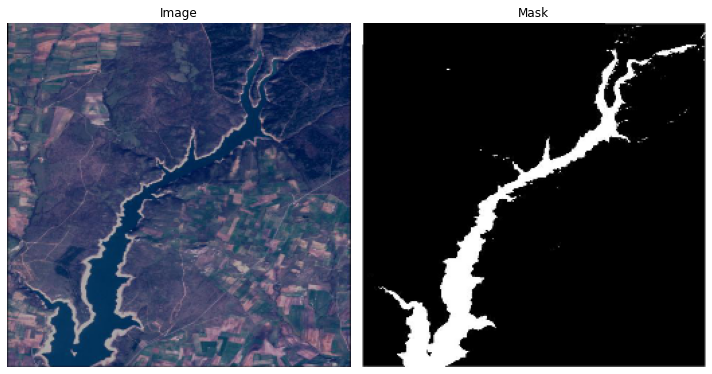



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


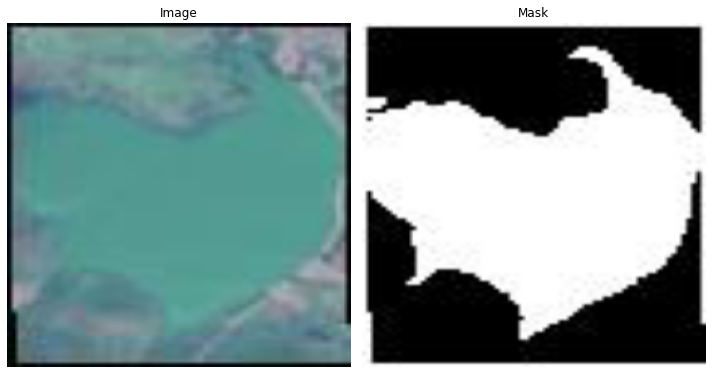



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


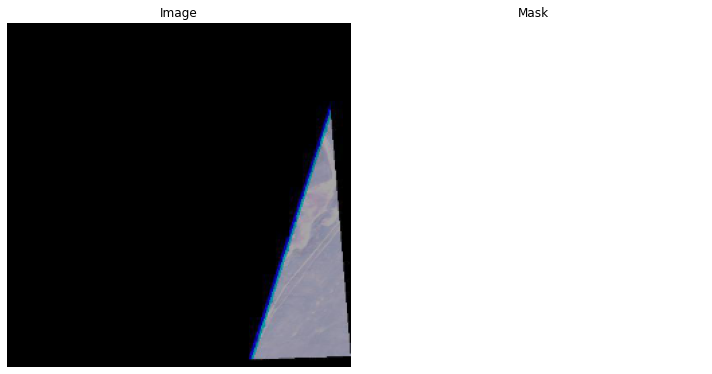



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


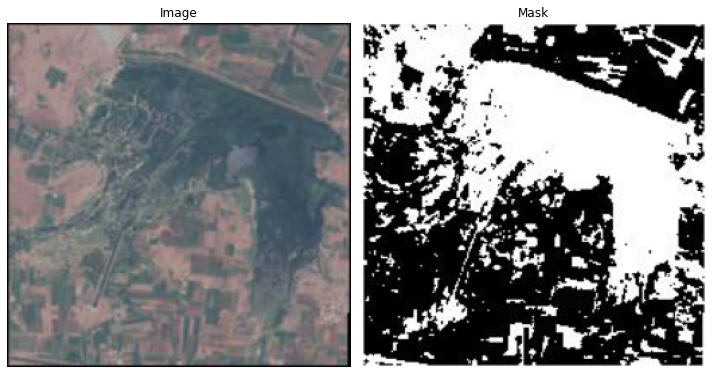



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


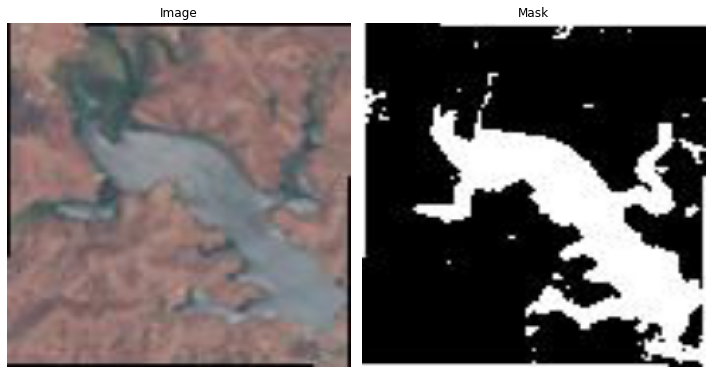



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


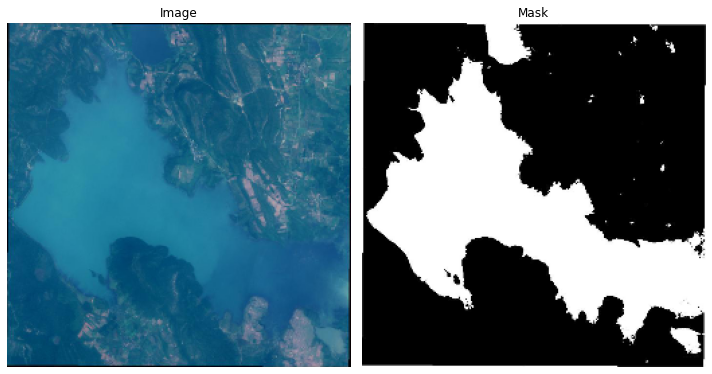



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


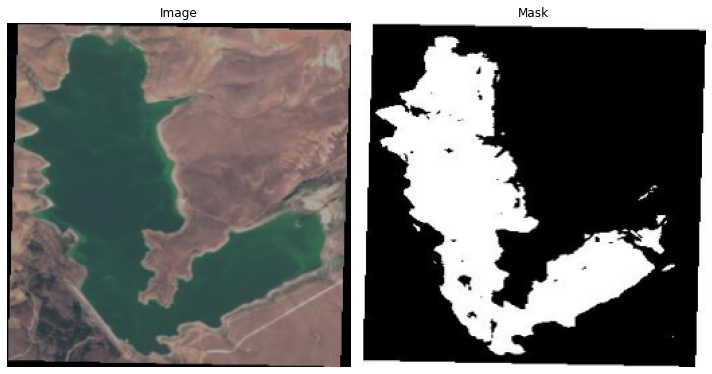



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


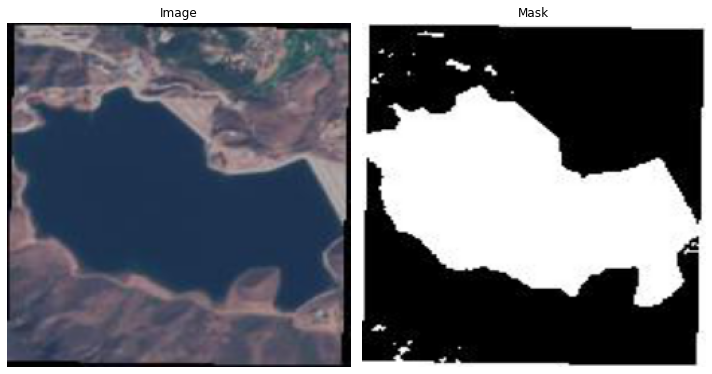



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


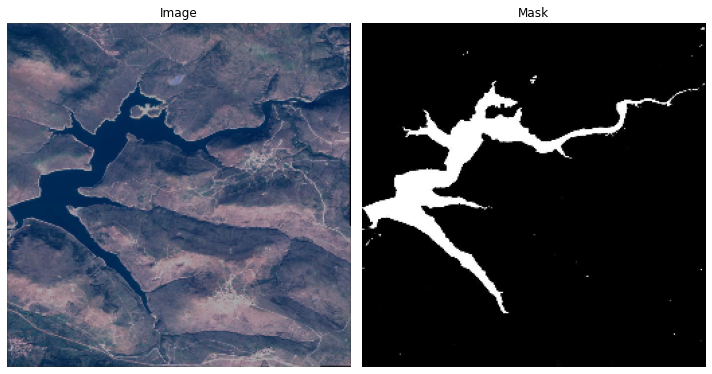



image shape: (256, 256, 3)
mask shape: (256, 256, 3)


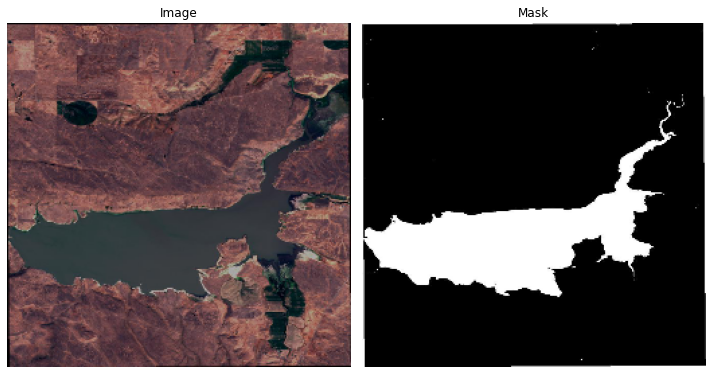

In [ ]:
# resize 확인
for idx in range(0, 100, 10):
    img = train_image[idx] 
    mask = train_mask[idx] 
    print('\n')
    print('image shape:', img.shape)
    print('mask shape:', mask.shape)

    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    plot_image(img, title="Image")
    
    plt.subplot(1,2,2)
    plot_image(mask, title="Mask")
    
    plt.tight_layout()
    plt.show()

# 2. Modeling

### 2-1. UNet

* 인코더의 각 단계에서는 MaxPooling을 이용하여 해상도를 단계마다 절반으로 압축
* 단계를 거쳐갈수록 결과의 해상도 크기가 감소, 대신 latent feature의 수가 증가

최초로 원저자가 적용한 원본과의 주요 차이점: 
* 입력과 출력 크기를 같게 구성
* 인코더(압축)-디코더(확장)를 연결하는 skip-connection 부분의 크기 역시 동일하게 구성(crop 불필요)


In [ ]:
# UNet
def UNet(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    enc1 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(inputs)
    enc1 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(enc1) # 1단계 압축 latent vector → 다음 단계로 전달하면서 동시에 skip-connection용으로 보관

    enc2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool1)
    enc2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(enc2) # 2단계 압축 latent vector → 다음 단계로 전달하면서 동시에 skip-connection용으로 보관

    enc3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool2)
    enc3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(enc3) # 3단계 압축 latent vector → 다음 단계로 전달하면서 동시에 skip-connection용으로 보관

    enc4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool3)
    enc4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(enc4) # 4단계 압축 latent vector
    pool4 = MaxPooling2D(pool_size=(2, 2))(enc4) # 4단계 압축 결과 → bridge로 전달

    # Bridge
    bridge = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(pool4) # 결과를 decoder로 전달

    # Decoder
    up4 = Conv2DTranspose(filters = 512, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(bridge)
    merge4 = concatenate([enc4, up4], axis = 3) # 4단계 압축 결과를 skip connection
    dec4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge4)
    dec4 = Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec4)

    up3 = Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec4)
    merge3 = concatenate([enc3, up3], axis = 3) # 3단계 압축 결과를 skip connection
    dec3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge3)
    dec3 = Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec3)

    up2 = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec3)
    merge2 = concatenate([enc2, up2], axis = 3) # 2단계 압축 결과를 skip connection
    dec2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge2)
    dec2 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec2)

    up1 = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2, activation = 'relu', padding = 'same')(dec2)
    merge1 = concatenate([enc1, up1], axis = 3) # 1단계 압축 결과를 skip connection
    dec1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(merge1)
    dec1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer="he_normal")(dec1)

    outputs = Conv2D(filters = 3, kernel_size = 1, activation = 'sigmoid', padding = 'same')(dec1)

    return Model(inputs = inputs, outputs = outputs)

In [ ]:
# 모델 구축
model = UNet(input_shape = (256, 256, 3))  # 입력 크기를 256 256으로 지정

# 모델 컴파일
model.compile(optimizer = Adam(),
              loss = 'binary_crossentropy') # 이진분류(0/1)이므로 binary_crossentropy 손실함수 사용

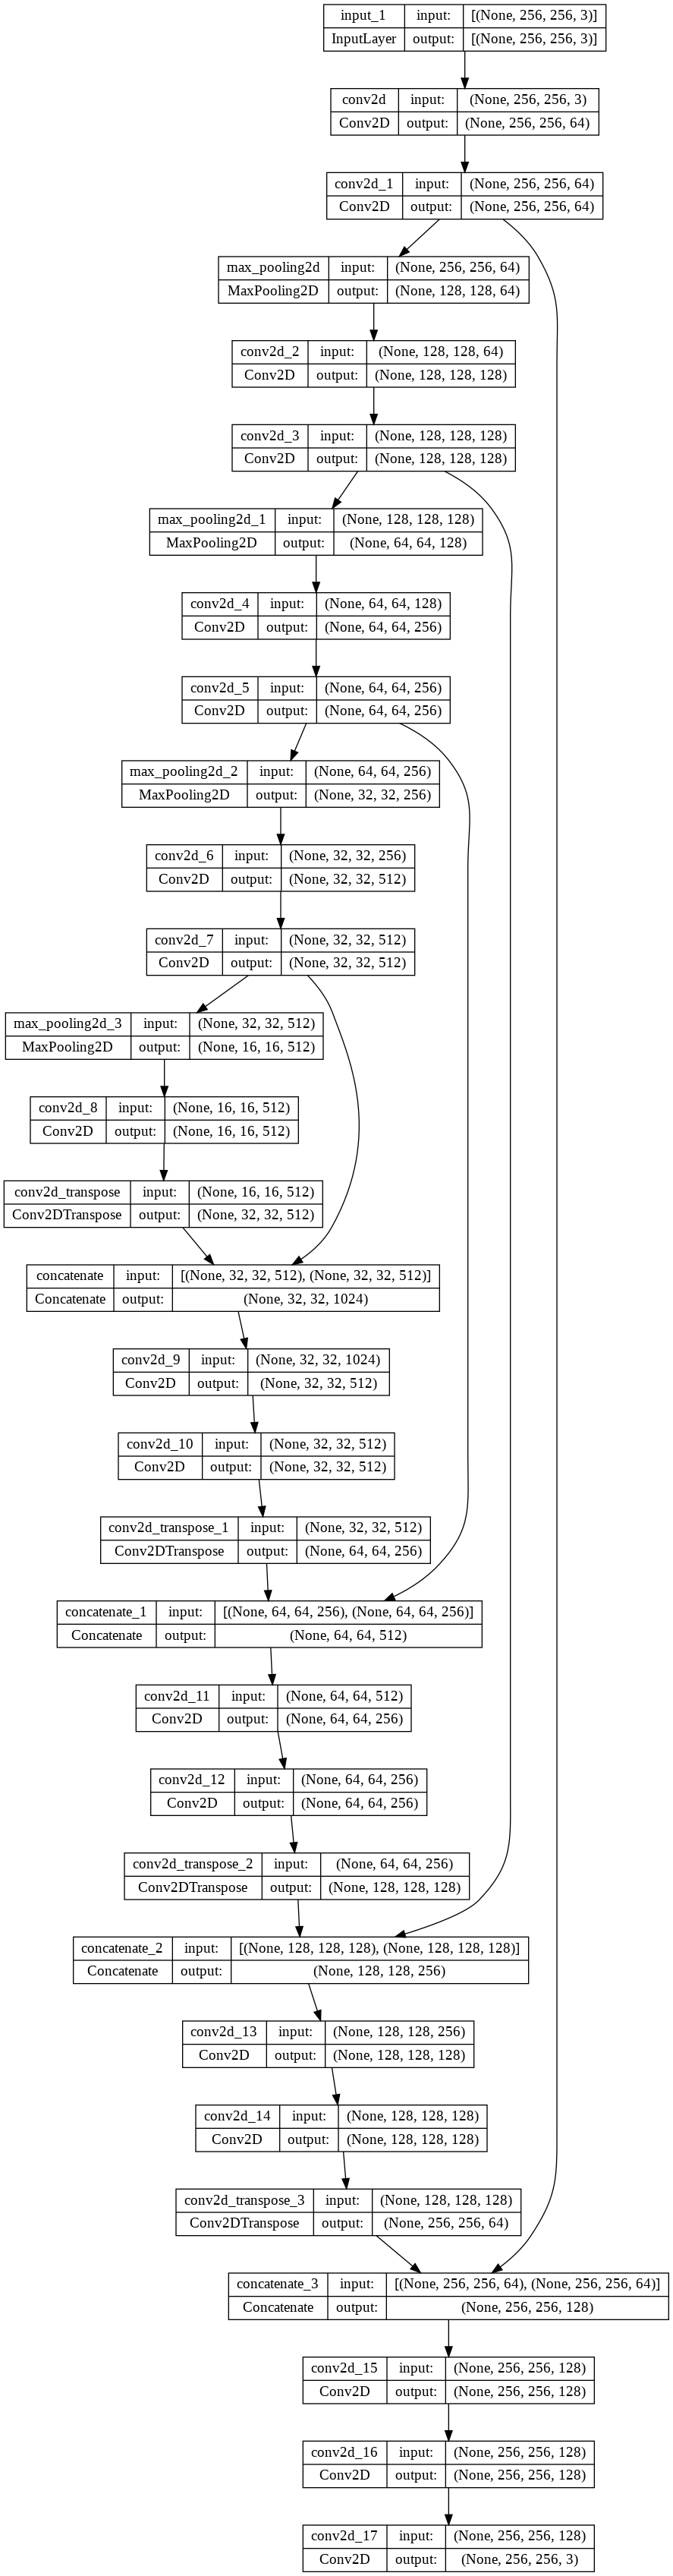

In [ ]:
# model architecture 확인 및 이미지 저장
plot_model(model, '/content/pretrained/UNet_architecture.png', show_shapes=True)

In [ ]:
# 초기 random weight
model.get_weights()[0]

array([[[[-0.27787665, -0.5649574 , -0.13750768, ...,  0.2858218 ,
           0.1004198 ,  0.12851188],
         [-0.44611552,  0.53949136, -0.5287449 , ...,  0.24564919,
          -0.02868945,  0.34382203],
         [-0.13371511, -0.15309046, -0.30528006, ..., -0.0592864 ,
          -0.55431384, -0.16469249]],

        [[-0.16423118, -0.41975075,  0.02931804, ..., -0.50233924,
          -0.05164813, -0.28378248],
         [ 0.10516824, -0.49113023, -0.03258517, ...,  0.19926083,
           0.40063703, -0.08066668],
         [ 0.14503288, -0.29968873,  0.11540524, ...,  0.35145116,
           0.1638933 ,  0.31454006]],

        [[ 0.09031168, -0.00819863, -0.44589517, ...,  0.06025135,
          -0.52486473,  0.00478465],
         [ 0.23555462,  0.50353885,  0.17557949, ..., -0.10876346,
          -0.29540658,  0.13532704],
         [ 0.49631792,  0.08701111,  0.1177059 , ..., -0.1643282 ,
          -0.1436963 , -0.17616136]]],


       [[[ 0.00866811,  0.37715214, -0.18868217, ...,  0

In [ ]:
# 초기 random weight 성능 평가
test_loss = model.evaluate(test_image, test_mask)
print('test loss:', test_loss)

4/4 [==============================] - 21s 1s/step - loss: 0.7700
test loss: 0.7700454592704773


1/1 [==============================] - 2s 2s/step


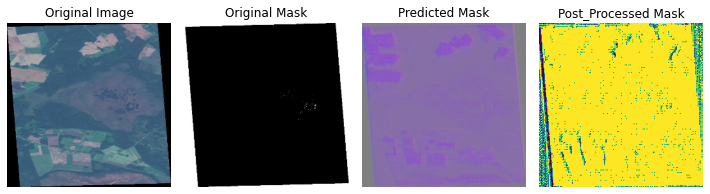

1/1 [==============================] - 0s 24ms/step


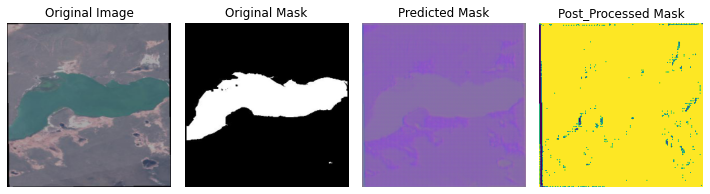

1/1 [==============================] - 0s 18ms/step


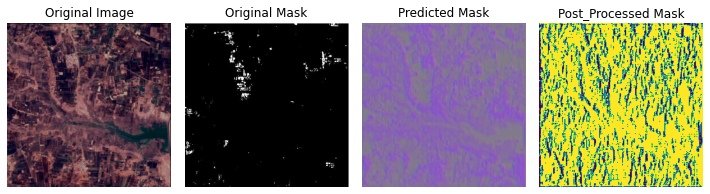

1/1 [==============================] - 0s 29ms/step


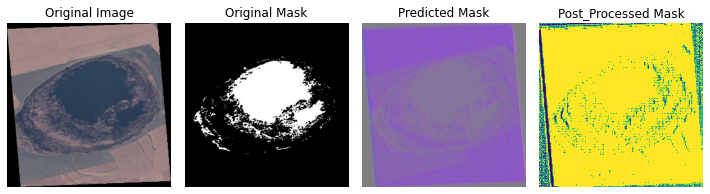

1/1 [==============================] - 0s 21ms/step


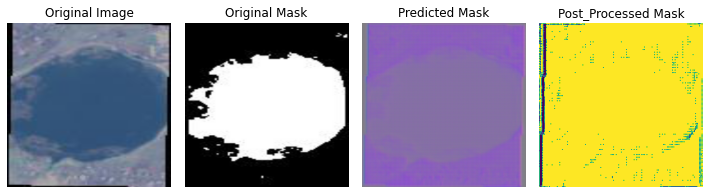

1/1 [==============================] - 0s 20ms/step


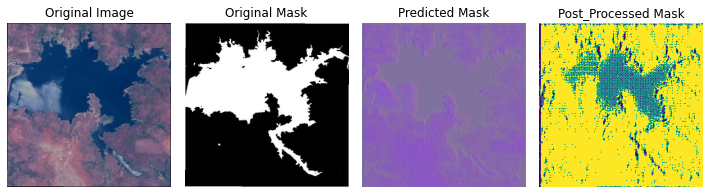

1/1 [==============================] - 0s 22ms/step


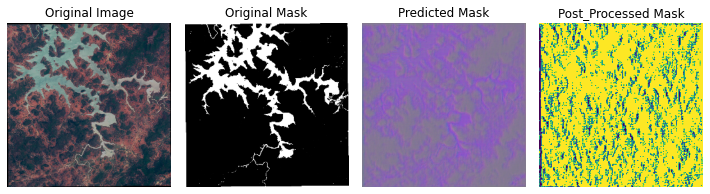

1/1 [==============================] - 0s 33ms/step


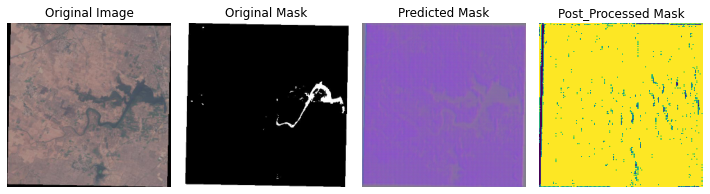

1/1 [==============================] - 0s 20ms/step


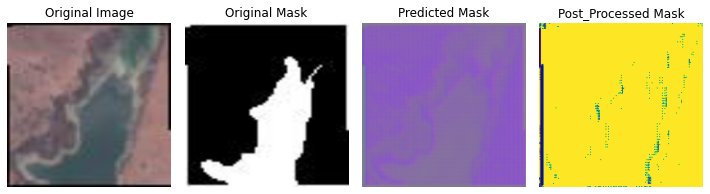

1/1 [==============================] - 0s 23ms/step


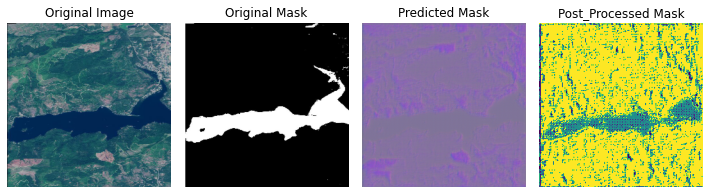

In [ ]:
# test
for idx in range(0, 100, 10):
    img = test_image[idx] 
    mask = test_mask[idx] 
    pred_mask = model.predict(tf.expand_dims(img,axis=0))[0]
    post_process = (pred_mask[:,:,0] > 0.5).astype('int')
        
    plt.figure(figsize=(10,8))
    plt.subplot(1,4,1)
    plot_image(img, title="Original Image")
        
    plt.subplot(1,4,2)
    plot_image(mask, title="Original Mask")
        
    plt.subplot(1,4,3)
    plot_image(pred_mask, title="Predicted Mask")
    
    plt.subplot(1,4,4)
    plot_image(post_process, title="Post_Processed Mask")
    
    plt.tight_layout()
    plt.show()

### 2-2. Pretrained model(사전에 일부 학습해놓은 모델 가중치) 불러오기

In [ ]:
# pre_trained weight load
model_path = '/content/pretrained/checkpoint'
model.load_weights(model_path)

# pre_trained weight
model.get_weights()[0]

array([[[[-0.6301747 ,  0.10737923,  0.3972483 , ..., -0.16492173,
           0.12011787,  0.4732224 ],
         [-0.063592  , -0.4202261 , -0.17233226, ..., -0.07007097,
           0.05614401, -0.10203952],
         [ 0.06305688, -0.39466476, -0.24019253, ...,  0.13573958,
           0.02138127, -0.3997395 ]],

        [[ 0.30444533,  0.4406024 , -0.10155246, ..., -0.3382085 ,
          -0.02433527, -0.25943753],
         [-0.29517308, -0.28763005, -0.3597521 , ..., -0.01743675,
           0.00310757, -0.10722342],
         [-0.5595281 ,  0.03309507, -0.08203679, ...,  0.27974427,
          -0.17120884,  0.10446392]],

        [[-0.39915252, -0.05924598,  0.0851664 , ..., -0.01753386,
          -0.10905977,  0.16278504],
         [-0.22882885, -0.05266162,  0.22367151, ...,  0.3093283 ,
           0.10574389,  0.01467978],
         [ 0.13890915,  0.36180672, -0.3647049 , ..., -0.2933313 ,
          -0.08847417, -0.02773259]]],


       [[[ 0.01428711, -0.22238591, -0.14084207, ...,  0

In [ ]:
# pre_trained weight 성능 평가
test_loss = model.evaluate(test_image, test_mask)
print('test loss:', test_loss)

4/4 [==============================] - 2s 458ms/step - loss: 0.2698
test loss: 0.26975318789482117


### 2-3. 학습

In [ ]:
# training
model_path = '/content/model/model_checkpoint'
model_checkpoint = ModelCheckpoint(filepath=model_path,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True,
                                   verbose=True)

model.fit(train_image, train_mask, epochs=20, batch_size=16, validation_split=0.2,
          callbacks=model_checkpoint)

Epoch 1/20
15/15 [==============================] - 32s 1s/step - loss: 0.2973 - val_loss: 0.3355
Epoch 2/20
15/15 [==============================] - 15s 1s/step - loss: 0.2748 - val_loss: 0.3181
Epoch 3/20
15/15 [==============================] - 15s 1s/step - loss: 0.2499 - val_loss: 0.3447
Epoch 4/20
15/15 [==============================] - 15s 1s/step - loss: 0.2575 - val_loss: 0.3330
Epoch 5/20
15/15 [==============================] - 15s 998ms/step - loss: 0.2427 - val_loss: 0.3553
Epoch 6/20
15/15 [==============================] - 15s 991ms/step - loss: 0.2349 - val_loss: 0.3470
Epoch 7/20
15/15 [==============================] - 15s 991ms/step - loss: 0.2211 - val_loss: 0.4209
Epoch 8/20
15/15 [==============================] - 15s 996ms/step - loss: 0.3276 - val_loss: 0.3829
Epoch 9/20
15/15 [==============================] - 15s 1s/step - loss: 0.3005 - val_loss: 0.3477
Epoch 10/20
15/15 [==============================] - 15s 1s/step - loss: 0.2678 - val_loss: 0.3974
Epoch 1

In [ ]:
# 학습 결과 성능 평가
test_loss = model.evaluate(test_image, test_mask)
print('test loss:', test_loss)

4/4 [==============================] - 2s 476ms/step - loss: 0.2903
test loss: 0.29034462571144104


### 2-4. 모델 저장하기

In [ ]:
# save weights => model construction & compile 필요
model_path = '/content/model'
model.save(f'{model_path}/UNet_best_checkpoint.ckp')

In [ ]:
# save model => model construction & compile 불필요
model_path = '/content/model'
model.save(f'{model_path}/UNet_best.h5')

# 3. Result

### 3-1. 모델 불러오기

In [ ]:
# model construction
model = UNet(input_shape = (256, 256, 3))  # resize shape

# model compile
model.compile(optimizer = Adam(),
              loss = 'binary_crossentropy')

# pre_trained weight load
model_path = '/content/model/model_checkpoint'
model.load_weights(model_path)

# 성능 평가
test_loss = model.evaluate(test_image, test_mask)
print('test loss:', test_loss)

4/4 [==============================] - 2s 477ms/step - loss: 0.2602
test loss: 0.26019594073295593


### 3-2. 시각화

1/1 [==============================] - 0s 245ms/step


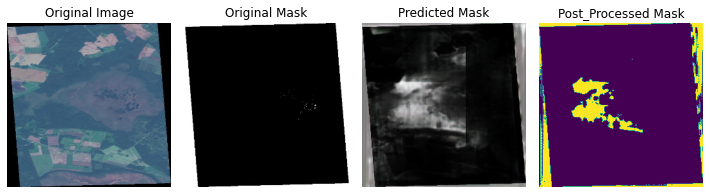

1/1 [==============================] - 0s 49ms/step


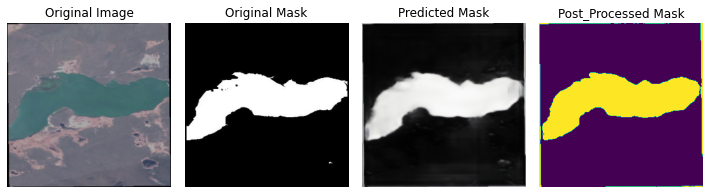

1/1 [==============================] - 0s 45ms/step


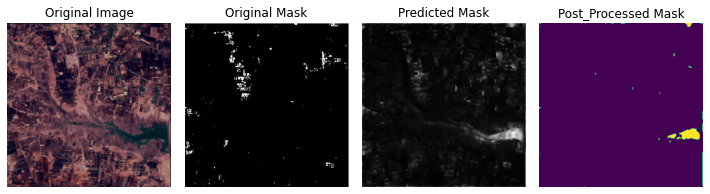

1/1 [==============================] - 0s 29ms/step


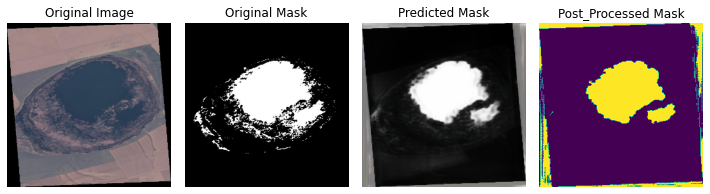

1/1 [==============================] - 0s 64ms/step


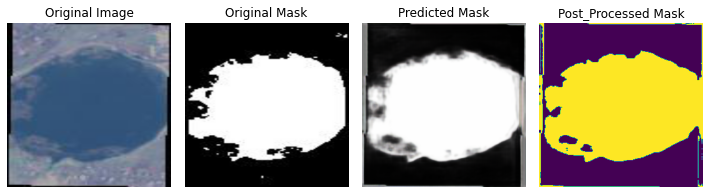

1/1 [==============================] - 0s 28ms/step


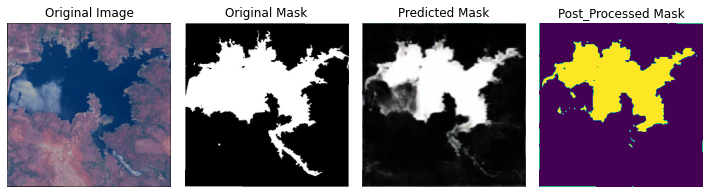

1/1 [==============================] - 0s 20ms/step


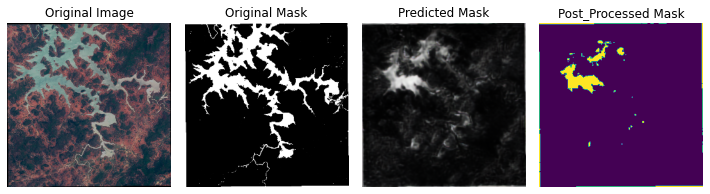

1/1 [==============================] - 0s 23ms/step


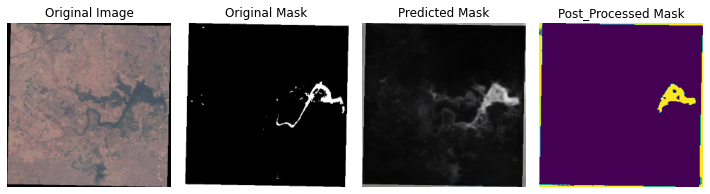

1/1 [==============================] - 0s 23ms/step


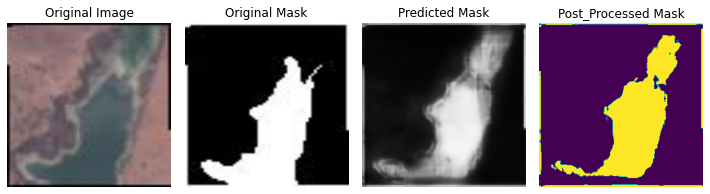

1/1 [==============================] - 0s 23ms/step


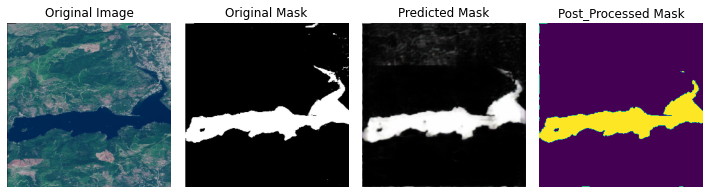

In [ ]:
for idx in range(0, 100, 10):
    img = test_image[idx] 
    mask = test_mask[idx] 
    pred_mask = model.predict(tf.expand_dims(img,axis=0))[0]
    post_process = (pred_mask[:,:,0] > 0.5).astype('int')
        
    plt.figure(figsize=(10,8))
    plt.subplot(1,4,1)
    plot_image(img, title="Original Image")
        
    plt.subplot(1,4,2)
    plot_image(mask, title="Original Mask")
        
    plt.subplot(1,4,3)
    plot_image(pred_mask, title="Predicted Mask")
    
    plt.subplot(1,4,4)
    plot_image(post_process, title="Post_Processed Mask")
    
    plt.tight_layout()
    plt.show()

# ※ 전체 데이터 다운로드
 * 위에 사용한 데이터는 전체 데이터의 약 10~20% 분량으로 충분한 성능을 내기에는 모집단 측면에서 많이 부족
 * 직접 연습할 시에는 아래에 링크된 전체 데이터셋을 활용하는 것을 권장
 * 다운로드 및 압축 해제 방식은 위에 사용한 데이터와 동일